In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import torch.nn.functional as F
from imutils import paths
import matplotlib.pyplot as plt

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])
torchvision.datasets.GTSRB(root='./data', split="train", download=True, transform=data_transforms)

100%|██████████| 187490228/187490228 [02:51<00:00, 1095612.56it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=[112, 112], interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [3]:
BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

In [4]:
train_data_path = "./data/gtsrb/GTSRB/Training"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")


trainloader = DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
valloader = DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

Number of training samples = 21312
Number of validation samples = 5328


In [5]:
class SimpleNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),

            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(12544, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [6]:
def evaluate( model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (images, labels) in loader:

            # Run predictions
            output, _ = model(images)
            _, predicted = torch.max(output, 1)
 
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1

In [7]:
# Function to perform training of the model

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:

        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        

        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()

    accuracy, recall, precision, f1 = evaluate(model, loader)

    return epoch_loss / len(loader), accuracy, recall, precision, f1

In [8]:
net = SimpleNet(numClasses)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
val_accuracy = 0

epoch = 1

net_losses = []

net_accuracies_train = []
net_recalls_train = []
net_precisions_train = []
net_f1_train = []

net_accuracies_val = []
net_recalls_val = []
net_precisions_val = []
net_f1_val = []


while val_accuracy < 0.95:
    train_loss, train_accuracy, train_recall, train_precision, train_f1 = train(net, trainloader, optimizer, criterion)

    val_accuracy, val_recall, val_precision, val_f1 = evaluate(net, valloader)




    print(f'Epoch {epoch }, Loss: {train_loss:.3f}')

    print(f'Training - Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}')

    print(f'Validation - Accuracy: {val_accuracy}, Recall: {val_recall}, Precision: {val_precision}, F1 Score: {val_f1}')
    

    net_losses.append(train_loss)
    
    net_accuracies_train.append(train_accuracy)
    net_recalls_train.append(train_recall)
    net_precisions_train.append(train_precision)
    net_f1_train.append(train_f1)

    net_accuracies_val.append(val_accuracy)
    net_recalls_val.append(val_recall)
    net_precisions_val.append(val_precision)
    net_f1_val.append(val_f1)

    epoch += 1

print('Finished Training')

/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Loss: 2.236
Training - Accuracy: 0.6798986486486487, Recall: 0.62571207040247, Precision: 0.7485890232304211, F1 Score: 0.6387002645313572
Validation - Accuracy: 0.6681681681681682, Recall: 0.6040506833796767, Precision: 0.7096076341990543, F1 Score: 0.6157110817239281
Epoch 2, Loss: 1.040
Training - Accuracy: 0.8309872372372372, Recall: 0.8213343420146515, Precision: 0.8785026137480902, F1 Score: 0.8366278678385671
Validation - Accuracy: 0.8125, Recall: 0.7921936519422572, Precision: 0.8591085819378569, F1 Score: 0.8077971822990254
Epoch 3, Loss: 0.745
Training - Accuracy: 0.8606418918918919, Recall: 0.8499857014252824, Precision: 0.8952744901926827, F1 Score: 0.8650487163347012
Validation - Accuracy: 0.8367117117117117, Recall: 0.8148306690668565, Precision: 0.8712461013507896, F1 Score: 0.8308325665536691
Epoch 4, Loss: 0.598
Training - Accuracy: 0.9047954204204204, Recall: 0.9039883481326745, Precision: 0.927281075433253, F1 Score: 0.912061884947181
Validation - Accuracy: 

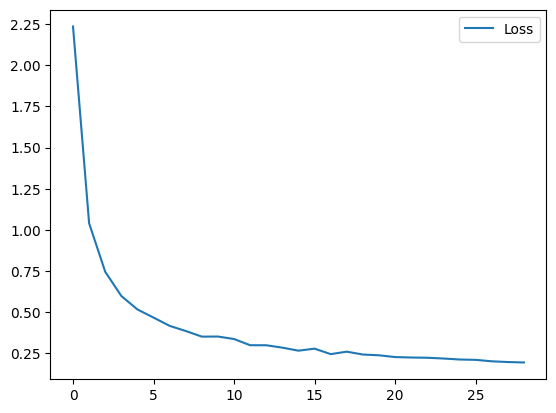

In [9]:
plt.plot(list(range(len(net_losses))), net_losses, label='Loss')
plt.legend()

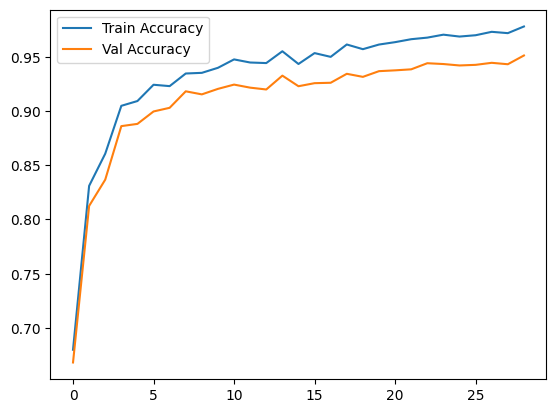

In [10]:
plt.plot(list(range(len(net_accuracies_train))), net_accuracies_train, label='Train Accuracy')
plt.plot(list(range(len(net_accuracies_val))), net_accuracies_val, label='Val Accuracy')
plt.legend()

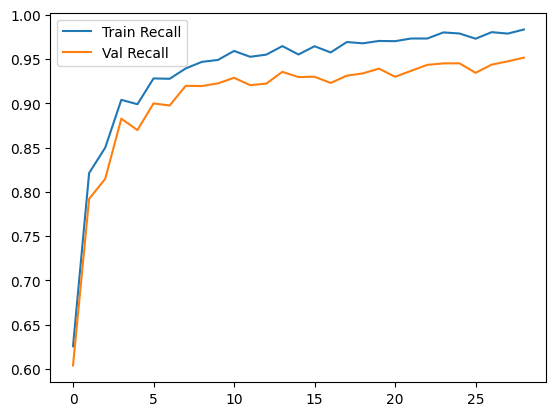

In [11]:
plt.plot(list(range(len(net_recalls_train))), net_recalls_train, label='Train Recall')
plt.plot(list(range(len(net_recalls_val))), net_recalls_val, label='Val Recall')
plt.legend()

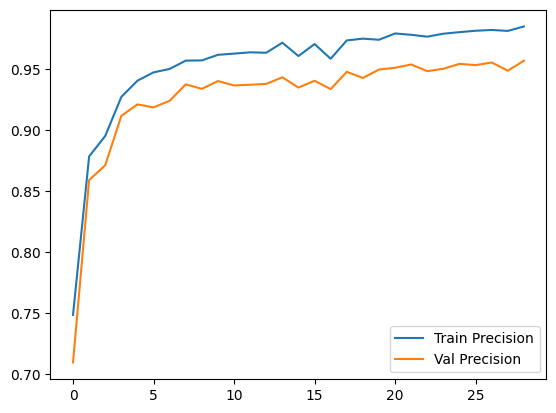

In [12]:
plt.plot(list(range(len(net_precisions_train))), net_precisions_train, label='Train Precision')
plt.plot(list(range(len(net_precisions_val))), net_precisions_val, label='Val Precision')
plt.legend()

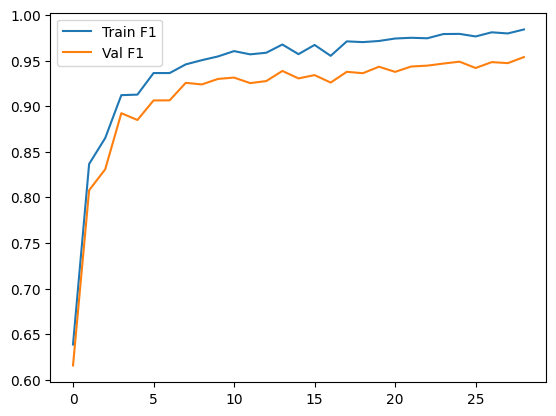

In [13]:
plt.plot(list(range(len(net_f1_train))), net_f1_train, label='Train F1')
plt.plot(list(range(len(net_f1_val))), net_f1_val, label='Val F1')
plt.legend()